In [86]:
# Import libraries..
import gym
from envs.binomial_tree import BinomialTree, decode_action, encode_action, plot_q_values    # custom BinomialTree dynamics
from envs import plotting
import numpy as np
import pandas as pd
import math
from collections import defaultdict
import itertools
import sys

Actions denote the fraction of wealth invested in the **risky asset**. Actions are discretized with a step size of 10%, i.e.

$$
\mathcal{A}=[0, 0.1, 0.2, \dots, 0.9, 1].
$$

In [3]:
actions = np.arange(0, 1.01, step=0.1)                  #vector of actions, discrete investment decisions in 10% steps
print("Actions (Investment in risky asset):", actions)  

Actions (Investment in risky asset): [0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]


Now we can create an instance of the environment. We use the class BinomialTree which simulates the price movements of a risky asset according to an two-step binomial tree with up/down probabilities $p_u = 4/9$ and $p_d=5/9$ and up and down returns $r_u=1$ (i.e. 100%) and $r_d=-1/2$ (i.e. -50%) and riskfree rate $r_f=0$, hence the riskfree rate satisfies
$$r_d < r_f < r_u.$$
Furthermore, we assume an initial wealth of 100 and a **square root utility function** $U(V_T)=\sqrt{V_T}$ of terminal wealth $V_T$. The rewards are zero at all time steps before termination and equal to $R_T=\sqrt{V_T}$ at termination.

In [4]:
# Creating the environment (class BinomalTree)

# using U(V_T)=sqrt(V_T)
#Inputs: up_prob, up_ret, down_ret, r, T, dt, V_0, actions, utility
env = BinomialTree(up_prob=4/9, up_ret=1, down_ret=-0.5, r=0, T=2, dt=1, V_0=100, actions=actions, utility="sqrt")

C:\tools\Anaconda3\lib\site-packages\gym\logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


States are represented as tuples $(n_t, V_t)$, where $n_t$ denotes the n-th timestep, i.e. if we take $T=5$ and $dt=0.5$ as an example, then the state $s=(0, 100)$ denotes the intial state (i.e. $V_0=100$) and $s=(3, 150)$ denotes the state of having a wealth of 150 at time $t=0+3*dt=1.5$ (i.e. $V_{1.5}=150$).\
Lets sample some steps from the environment...

In [5]:
# Simulation of BinomialTree dynamics
print(env.reset())      # Reset the environment to state (0, 100)
print(env.step(10))     # Take the action 10 (i.e. 90% investment in risky asset) and observe the next state and reward
print(env.step(10))     # Take the action 10 (i.e. 90% investment in risky asset) and observe the next state and reward
print(env.V_t)          # Prints the current wealth

(0, 100)
((1, 50.0), 0, False, {})
((2, 25.0), 5.0, True, {})
25.0


**Epsilon-Greedy Policy**\
Source: https://www.geeksforgeeks.org/q-learning-in-python/#:~:text=Q%2DLearning%20is%20a%20basic,defined%20for%20states%20and%20actions.

In [6]:
def createEpsilonGreedyPolicy(Q, epsilon, num_actions): 
    """ 
    Creates an epsilon-greedy policy based 
    on a given Q-function and epsilon. 
       
    Returns a function that takes the state 
    as an input and returns the probabilities 
    for each action in the form of a numpy array  
    of length of the action space(set of possible actions). 
    """
    def policyFunction(state): 
   
        Action_probabilities = np.ones(num_actions, 
                dtype = float) * epsilon / num_actions 
                  
        best_action = np.argmax(Q[state]) 
        Action_probabilities[best_action] += (1.0 - epsilon) 
        return Action_probabilities 
   
    return policyFunction

**Q-Learning Algorithm** \
Source: https://www.geeksforgeeks.org/q-learning-in-python/#:~:text=Q%2DLearning%20is%20a%20basic,defined%20for%20states%20and%20actions.

In [7]:
def qLearning(env, num_episodes, discount_factor = 1, alpha = 1, epsilon = 1): 
    """ 
    Q-Learning algorithm: Off-policy TD control. 
    Finds the optimal greedy policy while improving 
    following an epsilon-greedy policy
    """
       
    # Action value function 
    # A nested dictionary that maps 
    # state -> (action -> action-value). 
    Q = defaultdict(lambda: np.zeros(env.action_space.n)) 
    A = defaultdict(lambda: np.zeros(env.action_space.n))
   
    # Keeps track of useful statistics 
    stats = plotting.EpisodeStats( 
        episode_lengths = np.zeros(num_episodes), 
        episode_rewards = np.zeros(num_episodes))     
       
    # Create an epsilon greedy policy function 
    # appropriately for environment action space 
    policy = createEpsilonGreedyPolicy(Q, epsilon, env.action_space.n) 
       
    # For every episode
    returns=np.array([])
    terminal_wealths = np.array([])
    for ith_episode in range(num_episodes): 
           
        # Reset the environment and pick the first action 
        state = env.reset() 
           
        for t in itertools.count(): 
               
            # get probabilities of all actions from current state 
            action_probabilities = policy(state)
   
            # choose action according to  
            # the probability distribution 
            action = np.random.choice(np.arange( 
                      len(action_probabilities)), 
                       p = action_probabilities)
            A[state][action] += 1
   
            # take action and get reward, transit to next state 
            next_state, reward, done, _ = env.step(action)
   
            # Update statistics 
            stats.episode_rewards[ith_episode] += reward 
            stats.episode_lengths[ith_episode] = t
               
            # TD Update 
            best_next_action = np.argmax(Q[next_state])     
            td_target = reward + discount_factor * Q[next_state][best_next_action]
            td_delta = td_target - Q[state][action]
            Q[state][action] += (1/A[state][action]) * td_delta          # Dynamic Learning Rate alpha=1/#visits of state-action pair
                                                                         # ensures convergence see Sutton & Barto eq. (2.7)
            # done is True if episode terminated    
            if done: 
                returns = np.append(returns, reward)
                terminal_wealths=np.append(terminal_wealths, env.V_t)
                break
                   
            state = next_state
        
        if ith_episode % 10000 == 0:            
            print("Episode: {}, Mean Return: {}, Mean Wealth (V_T): {}, Epsilon: {}".format(ith_episode, round(returns.mean(), 3), round(terminal_wealths.mean(), 3), epsilon))
            #print("td_delta:", td_delta)
            returns = np.array([])
            terminal_wealths=np.array([])
            
        # Epsilon-Decay    
        if (ith_episode % 10000 == 0) & (ith_episode != 0):
            epsilon *= 0.98
            policy = createEpsilonGreedyPolicy(Q, epsilon, env.action_space.n)
        #    alpha = 0.1
        
        # Alpha-Decay
        #if (ith_episode % 30000 == 0) & (ith_episode != 0):
        #    if alpha > 0.0011:
        #        alpha *= 1/10
            
       
    return Q, stats, A

Now we can start training our agent...

In [8]:
# Training of the Agent
num_episodes = 2500000                     # Training for 2.5 mio. Episodes
Q, stats, A = qLearning(env, num_episodes)

Episode: 0, Mean Return: 6.124, Mean Wealth (V_T): 37.5, Epsilon: 1
Episode: 10000, Mean Return: 10.389, Mean Wealth (V_T): 117.402, Epsilon: 1
Episode: 20000, Mean Return: 10.395, Mean Wealth (V_T): 117.397, Epsilon: 0.98
Episode: 30000, Mean Return: 10.389, Mean Wealth (V_T): 117.032, Epsilon: 0.9603999999999999
Episode: 40000, Mean Return: 10.421, Mean Wealth (V_T): 117.884, Epsilon: 0.9411919999999999
Episode: 50000, Mean Return: 10.444, Mean Wealth (V_T): 118.653, Epsilon: 0.9223681599999999
Episode: 60000, Mean Return: 10.395, Mean Wealth (V_T): 117.399, Epsilon: 0.9039207967999998
Episode: 70000, Mean Return: 10.411, Mean Wealth (V_T): 118.189, Epsilon: 0.8858423808639998
Episode: 80000, Mean Return: 10.374, Mean Wealth (V_T): 117.091, Epsilon: 0.8681255332467198
Episode: 90000, Mean Return: 10.408, Mean Wealth (V_T): 118.17, Epsilon: 0.8507630225817854
Episode: 100000, Mean Return: 10.359, Mean Wealth (V_T): 117.145, Epsilon: 0.8337477621301497
Episode: 110000, Mean Return: 10.

Episode: 880000, Mean Return: 10.534, Mean Wealth (V_T): 130.199, Epsilon: 0.1724521389063193
Episode: 890000, Mean Return: 10.44, Mean Wealth (V_T): 120.622, Epsilon: 0.16900309612819292
Episode: 900000, Mean Return: 10.516, Mean Wealth (V_T): 122.003, Epsilon: 0.16562303420562907
Episode: 910000, Mean Return: 10.486, Mean Wealth (V_T): 121.738, Epsilon: 0.16231057352151648
Episode: 920000, Mean Return: 10.485, Mean Wealth (V_T): 121.798, Epsilon: 0.15906436205108615
Episode: 930000, Mean Return: 10.526, Mean Wealth (V_T): 121.734, Epsilon: 0.15588307481006441
Episode: 940000, Mean Return: 10.472, Mean Wealth (V_T): 124.977, Epsilon: 0.15276541331386312
Episode: 950000, Mean Return: 10.473, Mean Wealth (V_T): 121.998, Epsilon: 0.14971010504758586
Episode: 960000, Mean Return: 10.506, Mean Wealth (V_T): 125.121, Epsilon: 0.14671590294663414
Episode: 970000, Mean Return: 10.482, Mean Wealth (V_T): 122.126, Epsilon: 0.14378158488770146
Episode: 980000, Mean Return: 10.464, Mean Wealth (V

Episode: 1740000, Mean Return: 10.551, Mean Wealth (V_T): 122.928, Epsilon: 0.030346673687106588
Episode: 1750000, Mean Return: 10.522, Mean Wealth (V_T): 122.08, Epsilon: 0.029739740213364455
Episode: 1760000, Mean Return: 10.566, Mean Wealth (V_T): 123.072, Epsilon: 0.029144945409097164
Episode: 1770000, Mean Return: 10.481, Mean Wealth (V_T): 121.102, Epsilon: 0.02856204650091522
Episode: 1780000, Mean Return: 10.524, Mean Wealth (V_T): 122.289, Epsilon: 0.027990805570896914
Episode: 1790000, Mean Return: 10.556, Mean Wealth (V_T): 123.11, Epsilon: 0.027430989459478975
Episode: 1800000, Mean Return: 10.574, Mean Wealth (V_T): 123.198, Epsilon: 0.026882369670289397
Episode: 1810000, Mean Return: 10.502, Mean Wealth (V_T): 121.779, Epsilon: 0.026344722276883607
Episode: 1820000, Mean Return: 10.528, Mean Wealth (V_T): 122.387, Epsilon: 0.025817827831345935
Episode: 1830000, Mean Return: 10.536, Mean Wealth (V_T): 122.5, Epsilon: 0.025301471274719014
Episode: 1840000, Mean Return: 10.5

Since the returns have a high variance, we cannot really see an clear improvement in the following plots, but with the parameters specified as above we know that the agents learned the optimal investment decision of $a_t = 0.7\, \forall t$ if we achieve a mean wealth of around 124.

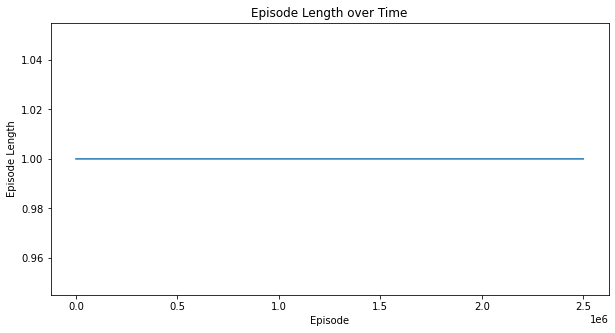

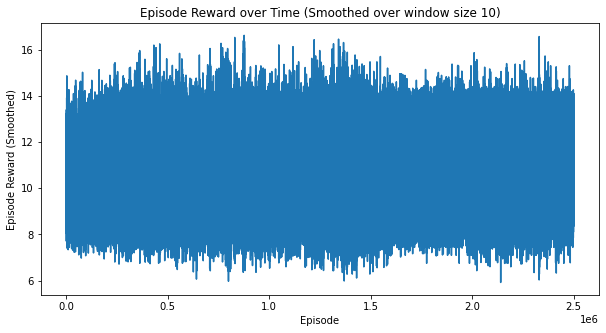

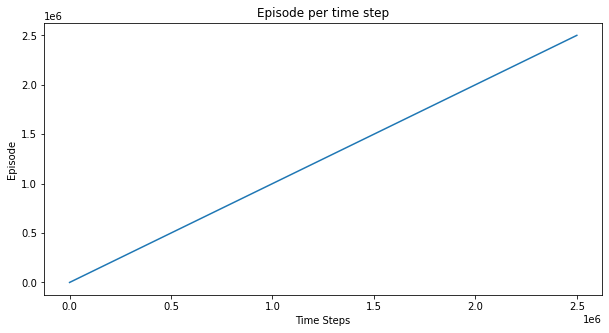

(<Figure size 720x360 with 1 Axes>,
 <Figure size 720x360 with 1 Axes>,
 <Figure size 720x360 with 1 Axes>)

In [9]:
plotting.plot_episode_stats(stats) 

Now we can print the Q-values for each state-action pair.

In [10]:
for key in Q.keys():
    print("Key:", key)
    print("State-Action Values:", Q[key], sep="\n")
    print("Best Action (Investment in risky asset):", decode_action(np.argmax(Q[key]), actions))

Key: (0, 100)
State-Action Values:
[10.31985885 10.40031045 10.48409914 10.55278187 10.55275654 10.55275409
 10.55267425 10.55343077 10.55276615 10.55271411 10.55251776]
Best Action (Investment in risky asset): 0.7000000000000001
Key: (1, 50.0)
State-Action Values:
[7.07106781 7.13189655 7.17484893 7.22766733 7.22144983 7.21556079
 7.27576229 7.27528964 7.27769303 7.22021738 7.15186916]
Best Action (Investment in risky asset): 0.8
Key: (2, 37.5)
State-Action Values:
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Best Action (Investment in risky asset): 0.0
Key: (1, 60.0)
State-Action Values:
[7.74596669 7.79657841 7.85269578 7.918023   7.92649345 7.91553489
 7.90441755 7.95222092 7.94794635 7.88751074 7.88095123]
Best Action (Investment in risky asset): 0.7000000000000001
Key: (2, 102.00000000000001)
State-Action Values:
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Best Action (Investment in risky asset): 0.0
Key: (1, 110.00000000000001)
State-Action Values:
[10.48808848 10.56609925 10.63521127 10.68435003 

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Best Action (Investment in risky asset): 0.0
Key: (2, 30.0)
State-Action Values:
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Best Action (Investment in risky asset): 0.0
Key: (2, 98.0)
State-Action Values:
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Best Action (Investment in risky asset): 0.0
Key: (2, 71.5)
State-Action Values:
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Best Action (Investment in risky asset): 0.0
Key: (2, 38.99999999999999)
State-Action Values:
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Best Action (Investment in risky asset): 0.0
Key: (2, 46.75000000000001)
State-Action Values:
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Best Action (Investment in risky asset): 0.0
Key: (2, 169.0)
State-Action Values:
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Best Action (Investment in risky asset): 0.0
Key: (2, 116.99999999999997)
State-Action Values:
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Best Action (Investment in risky asset): 0.0
Key: (2, 342.0)
State-Action Values:
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

In [11]:
# How often was each action take in each state
for key, value in A.items():
    print("State: {}, Actions: {}".format(key, value))

State: (0, 100), Actions: [  45361.   44890.   45239.   58458.  134126.  323770.  161105. 1012210.
  206838.  324814.  143189.]
State: (1, 50.0), Actions: [ 2262.  2159.  2235.  2141.  2188.  2135.  2873.  3406. 55581.  2217.
  2140.]
State: (1, 60.0), Actions: [ 1993.  1999.  1975.  2046.  3220.  2672.  2591. 91453.  2097.  2113.
  3083.]
State: (1, 110.00000000000001), Actions: [ 912.  921.  977.  954. 1619. 1711. 8925.  926.  924. 1008. 1060.]
State: (1, 140.0), Actions: [ 2230.  2280.  2241.  2303.  2253.  2881.  2271.  2364. 36387.  2178.
  2331.]
State: (1, 64.99999999999999), Actions: [  4324.   4279.   4216.   4199.   4264.   4332. 516128.   4266.   6890.
   4256.   4881.]
State: (1, 85.0), Actions: [ 1361.  1406.  1381.  1395.  1430.  1379.  2410.  1449.  4561. 13730.
  2004.]
State: (1, 200.0), Actions: [ 1795.  1700.  1721.  1754.  1783.  1728.  3023.  1942. 43778.  1834.
  2794.]
State: (1, 75.0), Actions: [  3759.   3637.   3706.   3625.   3589.   4377.   5289. 139527.   3

Now we can take a look at the Q-value surface for each state-action pair. The predicted optimal actions $argmax_a Q(s,a)$ are indicated as red dots.

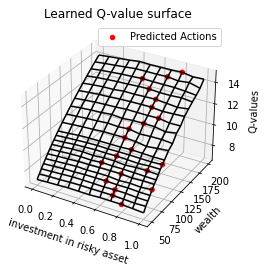

In [12]:
plot_q_values(Q, actions)

We can see that the Q-values seem to be reasonable, as the surface is smooth. The predicted actions take values in the set $\{0.5, 0.6, 0.7, 0.8, 0.9, 1\}$ and most predicted actions seem to be around $0.7$. Still we can observe that even for this small example and training for 2.5m episodes the Q-Learning cannot figure out the theoretical optimal strategy, which is $a_t=0.7\,\, \forall s \in \mathcal{S}$.  

In [13]:
# Training another Agent for only 5000 episodes
Q2, _, _ = qLearning(env, 5000)

Episode: 0, Mean Return: 8.746, Mean Wealth (V_T): 76.5, Epsilon: 1


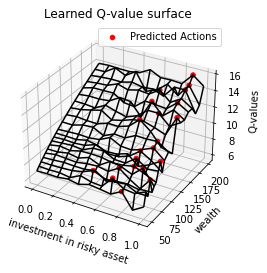

In [85]:
plot_q_values(Q2, actions)

We can observe that after 5000 episodes the Q-value surface is still very rigid. Hence, it seems that the Q-values have not converged yet, and longer training is necessary.

**Assessing the convergence of the Q-value function**

In [75]:
tracking_state = (1, 100.0)
num_episodes   = 50000
epsilon = 1
discount_factor = 1

# Action value function 
# A nested dictionary that maps 
# state -> (action -> action-value). 
Q3 = defaultdict(lambda: np.zeros(env.action_space.n)) 
A3 = defaultdict(lambda: np.zeros(env.action_space.n))
Q3_tracking_state = []

# Create an epsilon greedy policy function 
# appropriately for environment action space 
policy = createEpsilonGreedyPolicy(Q3, epsilon, env.action_space.n) 

# For every episode
for ith_episode in range(num_episodes): 

    # Reset the environment and pick the first action 
    state = env.reset() 

    for t in itertools.count(): 

        # get probabilities of all actions from current state 
        action_probabilities = policy(state)

        # choose action according to  
        # the probability distribution 
        action = np.random.choice(np.arange( 
                  len(action_probabilities)), 
                   p = action_probabilities)
        A3[state][action] += 1

        # take action and get reward, transit to next state 
        next_state, reward, done, _ = env.step(action)

        # TD Update 
        best_next_action = np.argmax(Q3[next_state])     
        td_target = reward + discount_factor * Q3[next_state][best_next_action]
        td_delta = td_target - Q3[state][action]
        Q3[state][action] += (1/A3[state][action]) * td_delta          # Dynamic Learning Rate alpha=1/#visits of state-action pair
                                                                     # ensures convergence see Sutton & Barto eq. (2.7)
        # Append updated value of tracking_state
        if state == tracking_state:
            Q3_tracking_state.append(list(Q3[state]))

        # done is True if episode terminated    
        if done: 
            break

        state = next_state

    # Epsilon-Decay    
    if (ith_episode % 10000 == 0) & (ith_episode != 0):
        epsilon *= 0.98
        policy = createEpsilonGreedyPolicy(Q3, epsilon, env.action_space.n)
        sys.stdout.write('\r'+("Episode {} of {}".format(ith_episode, num_episodes)))

Episode 40000 of 50000

In [76]:
# Select action for corresponding Q(tracking_state, tracking_action)
tracking_action = 7     # i.e. 70% investment in risky asset

Q_tracking_state_tracking_action = [state[8] for state in Q3_tracking_state]

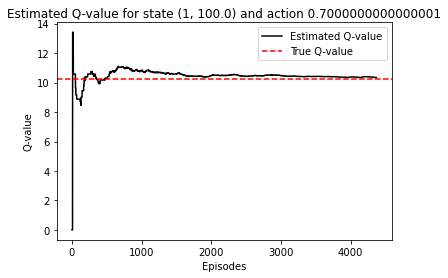

In [77]:
plt.plot(np.arange(1, len(Q_tracking_state_tracking_action)+1), Q_tracking_state_tracking_action, c="black", label="Estimated Q-value")
plt.axhline(y = 10.274, color = 'r', linestyle = '--', label="True Q-value") 
plt.legend()
plt.xlabel("Episodes")
plt.ylabel("Q-value")
plt.title("Estimated Q-value for state {} and action {}".format(tracking_state, decode_action(tracking_action, actions)))

plt.show()

The true Q-value for action $a_t = 0.7$ can be calculated as 
$$
\mathbb{E}[U(V_2) | V_1 = 100, a_1 = 0.7]
= \frac{4}{9}*\sqrt{100*0.7*2 + 100*(1-0.7)} + \frac{5}{9}*\sqrt{100*0.7*0.5 + 100*(1-0.7)} \approx 10.274
$$